# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

# 作業目標:
    
    取得各種優化器的運算結果

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import optimizers

#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


### Adam
* 調整 batch_size, epoch
    * batch_size = 64
    * eppch = 10

In [2]:
batch_size = 64
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model_by_Adam_6410.h5'

In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [6]:
# 輸出模型摘要資訊
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [7]:
#第三步編譯
adam =  optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [8]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Using real-time data augmentation.

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 95s 2ms/step - loss: 1.5592 - acc: 0.4319 - val_loss: 1.1913 - val_acc: 0.5754
Epoch 2/10
50000/50000 [==============================] - 94s 2ms/step - loss: 1.1632 - acc: 0.5873 - val_loss: 1.0503 - val_acc: 0.6318
Epoch 3/10
50000/50000 [==============================] - 93s 2ms/step - loss: 0.9985 - acc: 0.6468 - val_loss: 0.8850 - val_acc: 0.6922
Epoch 4/10
50000/50000 [==============================] - 93s 2ms/step - loss: 0.8947 - acc: 0.6851 - val_loss: 0.7969 - val_acc: 0.7208
Epoch 5/10
50000/50000 [==============================] - 92s 2ms/step - loss: 0.8277 - acc: 0.7090 - val_loss: 0.7486 - val_acc: 0.7406
Epoch 6/10
50000/50000 [==============================] - 92s 2ms/step - loss: 0.7728 - acc: 0.7297 - val_loss: 0.7173 - val_acc: 0.7484
Epoch 7/10
50000/50000 [====================

In [10]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at C:\Users\10709151\Documents\機器學習百日馬拉松\Day76\saved_models\keras_cifar10_trained_model_by_Adam_6410.h5 
10000/10000 [==============================] - 7s 674us/step
Test loss: 0.6750282322883606
Test accuracy: 0.7711


In [11]:
#    第六步：輸出
import numpy 
print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)

result = model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

 test set 

 The test loss is %f  [0.6750282204151153, 0.7710999989509583]


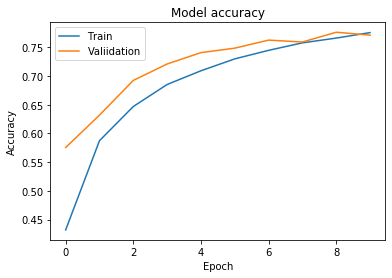

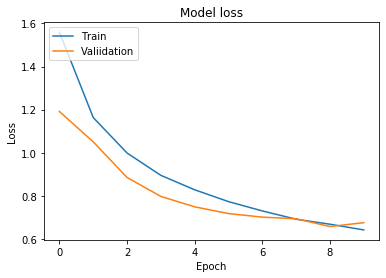

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

### Adam
* 調整 batch_size, epoch
    * batch_size = 32
    * eppch = 10

In [13]:
batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model_by_Adam_3210.h5'

In [14]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [15]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [16]:
#第三步編譯
adam =  optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [18]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 105s 2ms/step - loss: 1.5095 - acc: 0.4490 - val_loss: 1.1511 - val_acc: 0.5808
Epoch 2/10
50000/50000 [==============================] - 105s 2ms/step - loss: 1.0986 - acc: 0.6127 - val_loss: 0.9025 - val_acc: 0.6861
Epoch 3/10
50000/50000 [==============================] - 105s 2ms/step - loss: 0.9404 - acc: 0.6728 - val_loss: 0.8363 - val_acc: 0.7080
Epoch 4/10
50000/50000 [==============================] - 105s 2ms/step - loss: 0.8481 - acc: 0.7044 - val_loss: 0.7267 - val_acc: 0.7418
Epoch 5/10
50000/50000 [==============================] - 104s 2ms/step - loss: 0.7842 - acc: 0.7243 - val_loss: 0.7069 - val_acc: 0.7526
Epoch 6/10
50000/50000 [==============================] - 105s 2ms/step - loss: 0.7412 - acc: 0.7408 - val_loss: 0.7217 - val_acc: 0.7510
Epoch 7/10
50000/50000 [==============================] - 106s 2ms/step - loss: 0.7051

In [19]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at C:\Users\10709151\Documents\機器學習百日馬拉松\Day76\saved_models\keras_cifar10_trained_model_by_Adam_3210.h5 
10000/10000 [==============================] - 7s 686us/step
Test loss: 0.6827323211669922
Test accuracy: 0.7638


In [20]:
#    第六步：輸出
import numpy 

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)

result = model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

 test set 

 The test loss is %f  [0.6827323067188263, 0.7637999987602234]


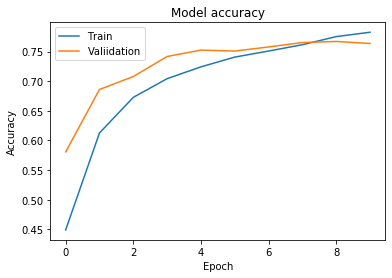

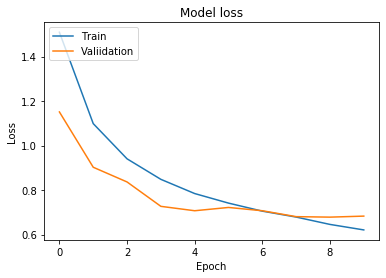

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

### Adam
* 調整 batch_size, epoch
    * batch_size = 1024
    * eppch = 10

In [22]:
batch_size = 1024
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model_by_Adam_102410.h5'

In [23]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [24]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [25]:
#第三步編譯
adam =  optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [26]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [27]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 69s 1ms/step - loss: 1.9709 - acc: 0.2676 - val_loss: 1.6656 - val_acc: 0.3961
Epoch 2/10
50000/50000 [==============================] - 68s 1ms/step - loss: 1.5908 - acc: 0.4164 - val_loss: 1.4403 - val_acc: 0.4791
Epoch 3/10
50000/50000 [==============================] - 67s 1ms/step - loss: 1.4353 - acc: 0.4786 - val_loss: 1.3179 - val_acc: 0.5297
Epoch 4/10
50000/50000 [==============================] - 67s 1ms/step - loss: 1.3116 - acc: 0.5279 - val_loss: 1.1795 - val_acc: 0.5820
Epoch 5/10
50000/50000 [==============================] - 68s 1ms/step - loss: 1.2173 - acc: 0.5636 - val_loss: 1.1063 - val_acc: 0.6118
Epoch 6/10
50000/50000 [==============================] - 67s 1ms/step - loss: 1.1376 - acc: 0.5961 - val_loss: 1.0385 - val_acc: 0.6351
Epoch 7/10
50000/50000 [==============================] - 68s 1ms/step - loss: 1.0676 - acc:

In [28]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at C:\Users\10709151\Documents\機器學習百日馬拉松\Day76\saved_models\keras_cifar10_trained_model_by_Adam_102410.h5 
10000/10000 [==============================] - 7s 674us/step
Test loss: 0.8617714292526245
Test accuracy: 0.7002


In [29]:
print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)

result = model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

 test set 

 The test loss is %f  [0.8617714285850525, 0.7001999998092652]


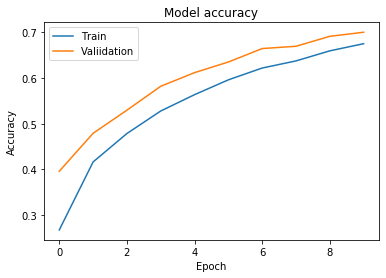

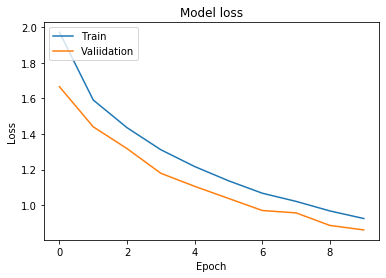

In [30]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

### 結論1
* batch_size = 64 eppch = 10
    *  The test loss is [0.6750282204151153, 0.7710999989509583]
    
* batch_size = 32 eppch = 10
    *  The test loss is [0.6827323067188263, 0.7637999987602234]
 
* batch_size = 1024 eppch = 10
     * The test loss is [0.8617714285850525, 0.7001999998092652]


#### same eppch, diff batch_size -> batch_size不見得越大越好

### SGD accurancy
    * batch_size = 64
    * eppch = 10

In [37]:
batch_size = 64
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
model_name = 'keras_cifar10_trained_model_by_SGD.h5'

In [38]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [39]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [40]:
#第三步編譯
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [41]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [42]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 91s 2ms/step - loss: 2.2090 - acc: 0.1716 - val_loss: 2.0343 - val_acc: 0.2660
Epoch 2/10
50000/50000 [==============================] - 89s 2ms/step - loss: 2.0360 - acc: 0.2443 - val_loss: 1.9523 - val_acc: 0.2928
Epoch 3/10
50000/50000 [==============================] - 90s 2ms/step - loss: 1.9771 - acc: 0.2724 - val_loss: 1.8900 - val_acc: 0.3274
Epoch 4/10
50000/50000 [==============================] - 89s 2ms/step - loss: 1.9097 - acc: 0.3040 - val_loss: 1.8145 - val_acc: 0.3610
Epoch 5/10
50000/50000 [==============================] - 89s 2ms/step - loss: 1.8309 - acc: 0.3327 - val_loss: 1.7247 - val_acc: 0.3879
Epoch 6/10
50000/50000 [==============================] - 89s 2ms/step - loss: 1.7682 - acc: 0.3518 - val_loss: 1.6704 - val_acc: 0.4025
Epoch 7/10
50000/50000 [==============================] - 88s 2ms/step - loss: 1.7253 - acc:

Saved trained model at C:\Users\10709151\Documents\機器學習百日馬拉松\Day76\saved_models\keras_cifar10_trained_model_by_SGD.h5 
10000/10000 [==============================] - 7s 680us/step
Test loss: 1.5570090339660645
Test accuracy: 0.4338
 test set 

 The test loss is %f  [1.5570090365409852, 0.4337999999523163]


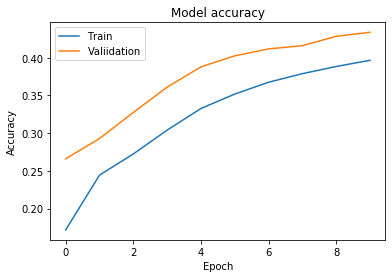

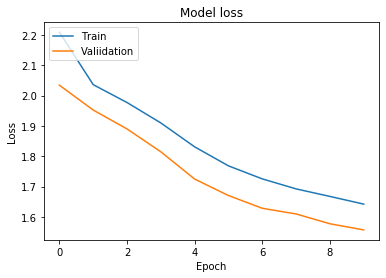

In [43]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)

result = model.predict(x_test,batch_size=200,verbose= 0)
result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )
result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

### Rmsprop accurancy
    * batch_size = 64
    * eppch = 10

In [44]:
batch_size = 64
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
model_name = 'keras_cifar10_trained_model_by_Rmsprop.h5'

In [45]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [46]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [47]:
#第三步編譯
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer = rmsprop, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [48]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [49]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 93s 2ms/step - loss: 1.6271 - acc: 0.4158 - val_loss: 1.4852 - val_acc: 0.4947
Epoch 2/10
50000/50000 [==============================] - 92s 2ms/step - loss: 1.1830 - acc: 0.5855 - val_loss: 1.3092 - val_acc: 0.5296
Epoch 3/10
50000/50000 [==============================] - 92s 2ms/step - loss: 0.9991 - acc: 0.6527 - val_loss: 1.1170 - val_acc: 0.6260
Epoch 4/10
50000/50000 [==============================] - 92s 2ms/step - loss: 0.9163 - acc: 0.6845 - val_loss: 0.9215 - val_acc: 0.6971
Epoch 5/10
50000/50000 [==============================] - 92s 2ms/step - loss: 0.8840 - acc: 0.7003 - val_loss: 1.0618 - val_acc: 0.6547
Epoch 6/10
50000/50000 [==============================] - 93s 2ms/step - loss: 0.8599 - acc: 0.7116 - val_loss: 0.8449 - val_acc: 0.7261
Epoch 7/10
50000/50000 [==============================] - 92s 2ms/step - loss: 0.8493 - acc:

Saved trained model at C:\Users\10709151\Documents\機器學習百日馬拉松\Day76\saved_models\keras_cifar10_trained_model_by_Rmsprop.h5 
10000/10000 [==============================] - 7s 688us/step
Test loss: 0.9402482594490051
Test accuracy: 0.6929
 test set 

 The test loss is %f  [0.9402482604980469, 0.6929000020027161]


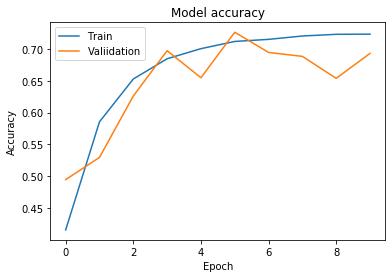

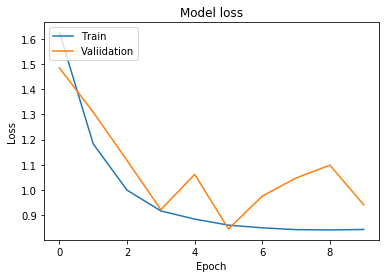

In [50]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)

result = model.predict(x_test,batch_size=200,verbose= 0)
result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )
result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

### Adam accurancy
* The test loss is [0.6750282204151153, 0.7710999989509583]

### SGD accurancy
* The test loss is [1.5570090365409852, 0.4337999999523163]

### Rmsprop accurancy
*  The test loss is [0.9402482604980469, 0.6929000020027161]